In [107]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
import torchvision
from torchvision import datasets, transforms
from torchinfo import summary
import requests
import zipfile
import pathlib
from pathlib import Path
import os
import random 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer
import warnings
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Get data

In [4]:
data_path = Path('data/')
img_path = data_path / 'pizza_steak_sushi'

if img_path.is_dir():
    print(f'{img_path} directory exists')
else:
    print(f'Did not find {img_path} directory, creating one...')
    img_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
        print(f'Downloading data...')
        f.write(request.content)
    with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
        print('Unzipping data...')
        zip_ref.extractall(img_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping data...


### Data Preparation

In [6]:
def walk_through_dir(dir_path):
    for dir_path, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}')

In [7]:
walk_through_dir(img_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [8]:
# Setup training and testing paths
train_dir = img_path / 'train'
test_dir = img_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#### Visualize an image

Random img path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


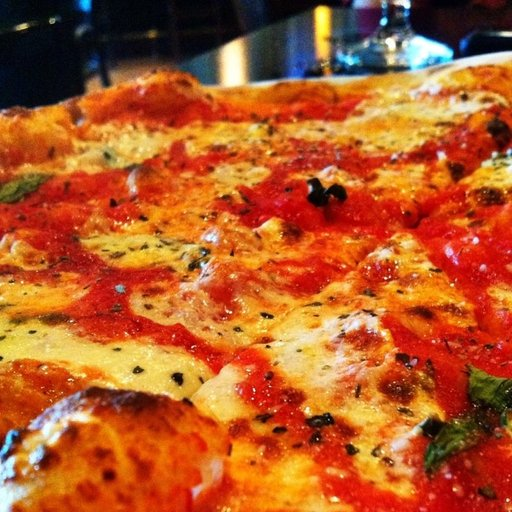

In [20]:
# Set seed
random.seed(42)

img_path_list = list(img_path.glob('*/*/*.jpg'))
random_img_path = random.choice(img_path_list)
img_class = random_img_path.parent.stem
img = Image.open(random_img_path)
print(f'Random img path: {random_img_path}')
print(f'Image class: {img_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

(-0.5, 511.5, 511.5, -0.5)

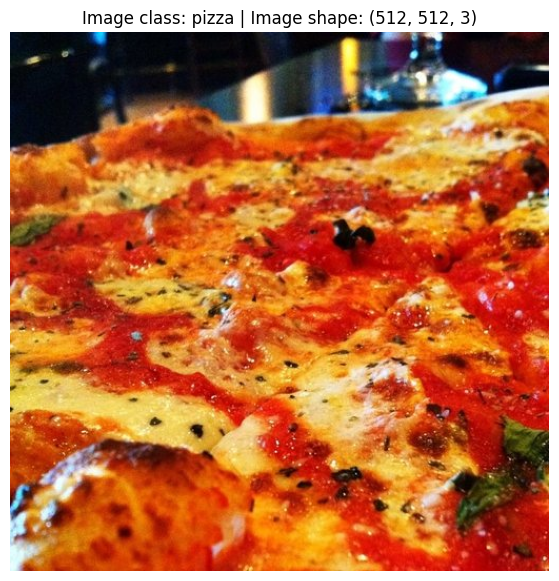

In [21]:
# Same thing with matplotlib
img_as_array = np.asarray(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {img_class} | Image shape: {img_as_array.shape}')
plt.axis(False)

### Transforming your data

In [28]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip images randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn them into tensors
    transforms.ToTensor()
])

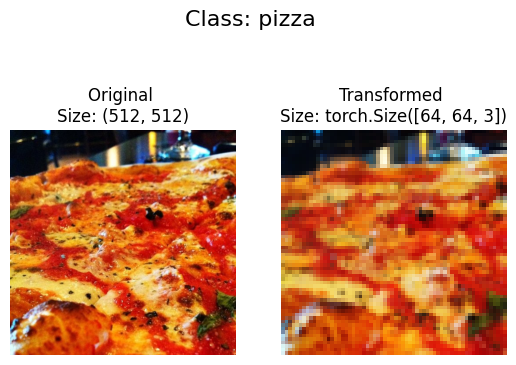

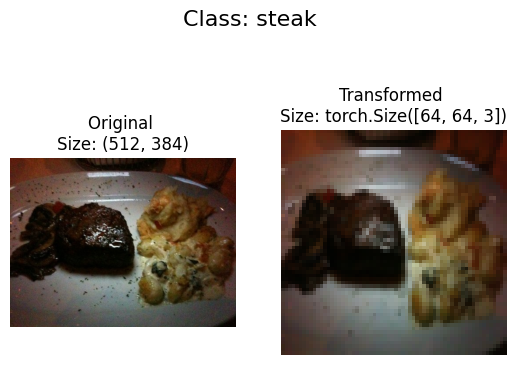

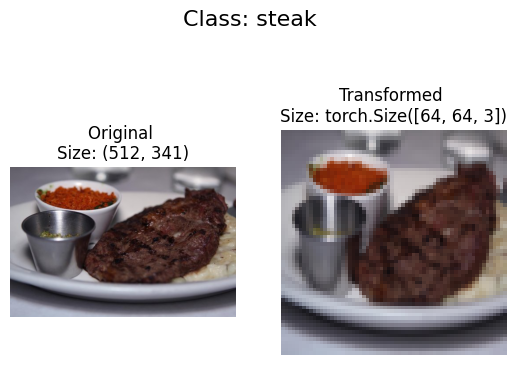

In [31]:
def plot_transformed_images(img_paths, transform, n = 3, seed = 42):
    random.seed(seed)
    random_img_paths = random.sample(img_paths, k=n)
    for img_path in random_img_paths:
        with Image.open(img_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original \nSize: {f.size}')
            ax[0].axis('off')

            transformed_img = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_img)
            ax[1].set_title(f'Transformed \nSize: {transformed_img.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {img_path.parent.stem}', fontsize = 16)

plot_transformed_images(img_path_list, data_transform, n=3)

### Option 1: Loading Image Data using ImageFolder

In [32]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)
test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform
)
print(f'Train data:\n{train_data}\nTest data:\n{test_data}')

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [33]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [34]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
len(train_data), len(test_data)

(225, 75)

In [37]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original img shape: torch.Size([3, 64, 64])
Permuted image shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

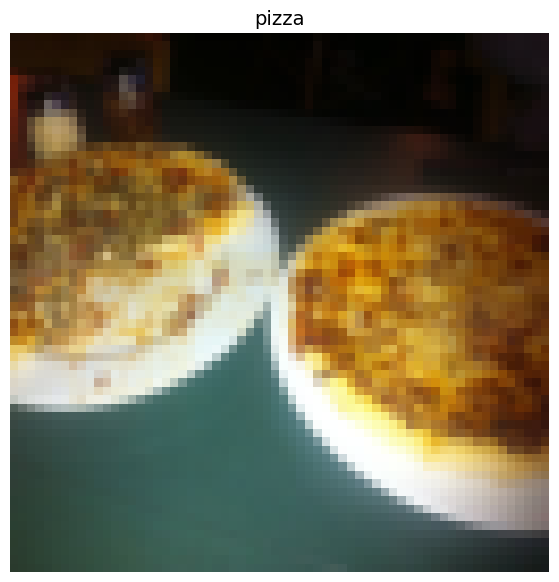

In [38]:
img_permute = img.permute(1, 2, 0) # matplotlib prefers in HWC format
print(f'Original img shape: {img.shape}')
print(f'Permuted image shape: {img_permute.shape}')
# Plot image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize = 14)

#### Turn loaded images into Dataloaders

In [39]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=1,
    shuffle=True,
    num_workers=1
)
test_loader = DataLoader(
    dataset=test_data,
    batch_size=1,
    shuffle=False,
    num_workers=1
)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x28a6f1a50>,
 <torch.utils.data.dataloader.DataLoader at 0x28886bfd0>)

In [41]:
img, label = next(iter(train_loader))
print(f'Image shape: {img.shape}')
print(f'Label shape: {label.shape}')

/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


### Option 2: Loading image data with a custom Dataset

#### Creating helper function to get class names

In [43]:
target_directory = train_dir
print(f'Target directory: {target_directory}')
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
print(f'Class names: {class_names_found}')

Target directory: data/pizza_steak_sushi/train
Class names: ['pizza', 'steak', 'sushi']


In [44]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in list(os.scandir(directory)))
    if not classes:
        raise FileNotFoundError(f'Couldn\'t find any classes in {directory}')
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [45]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### Create custom Dataset to replicate ImageFolder

In [47]:
class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transforms = None) -> None:
        self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg'))
        self.transform = transforms
        self.classes, self.class_to_idx = find_classes(target_dir)
    
    def load_image(self, index: int) -> Image.Image:
        img_path = self.paths[index]
        return Image.open(img_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [48]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [49]:
train_data_custom = ImageFolderCustom(target_dir=train_dir, transforms=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir, transforms=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x28a72dc90>,
 <__main__.ImageFolderCustom at 0x28a7a8e50>)

In [50]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [51]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [52]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [54]:
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


#### Create a function to display random images

In [61]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n>10:
        n = 10
        display_shape = False
        print(f'For display purposes, n should not be larger than 10')
    
    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k = n)
    # Setup plot
    plt.figure(figsize=(16, 8))
    for i, targ_sample in enumerate(random_samples_idx):
        targ_img, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_img_adjust = targ_img.permute(1, 2, 0)
        plt.subplot(1, n, i+1)
        plt.imshow(targ_img_adjust)
        plt.axis('off')
        if classes:
            title = f'class: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_img_adjust.shape}'
        plt.title(title)

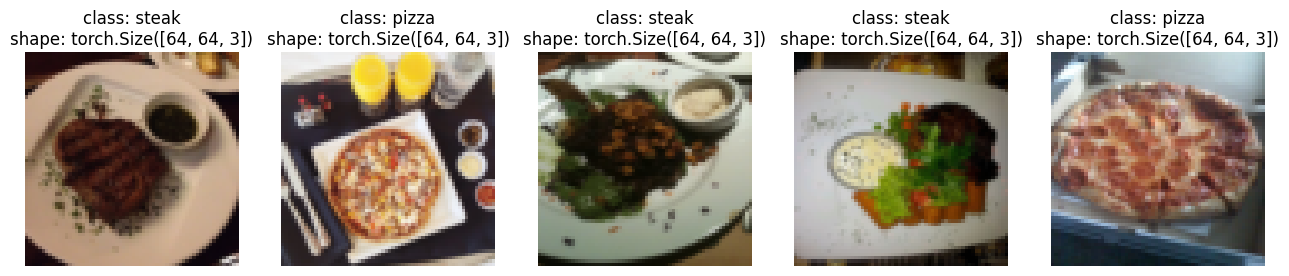

In [62]:
display_random_images(
    train_data,
    n=5,
    classes=class_names,
    seed=None
)

For display purposes, n should not be larger than 10


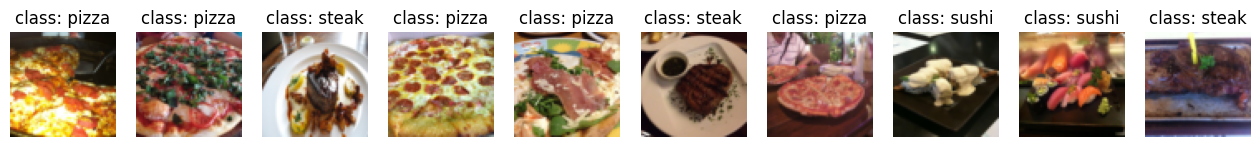

In [63]:
display_random_images(
    train_data_custom,
    n=12,
    classes=class_names,
    seed=None
)

#### Turn custom loaded images into Dataloaders

In [67]:
train_loader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=1,
    num_workers=0,
    shuffle=True
)

test_loader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=1,
    num_workers=0,
    shuffle=False
)
train_loader_custom, test_loader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1589b2d90>,
 <torch.utils.data.dataloader.DataLoader at 0x1589b0d90>)

In [68]:
imgcustom, labelcustom = next(iter(train_loader_custom))
print(f'Image shape: {imgcustom.shape}')
print(f'Label shape: {labelcustom.shape}')

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


### Model 0: TinyVGG without data augmentation

#### Creating transforms and loading data for Model 0

In [69]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [71]:
train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform
)
test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

batch_size = 32
num_workers = os.cpu_count()
print(f'Creating dataloader with {batch_size} batch_size and {num_workers} num_workers')
train_loader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
)
test_loader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)
train_loader_simple, test_loader_simple

Creating dataloader with 32 batch_size and 8 num_workers


(<torch.utils.data.dataloader.DataLoader at 0x158e5ec10>,
 <torch.utils.data.dataloader.DataLoader at 0x1589fbe50>)

#### Create TinyVGG model class

In [73]:
class TinyVGG(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_dim*16*16, out_features=output_dim)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model_0 = TinyVGG(input_dim=3, hidden_dim=10, output_dim=len(class_names)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

#### Try forward pass on single image

In [74]:
img_batch, label_batch = next(iter(train_loader_simple))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f'Sample image shape: {img_single.shape}')
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

print(f'Logits:\n{pred}\n')
print(f'Pred Probs:\n{torch.softmax(pred, dim=1)}\n')
print(f'Pred label:\n{torch.argmax(torch.softmax(pred, dim=1),dim=1)}')
print(f'Actual label:\n{label_single}')

/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Sample image shape: torch.Size([1, 3, 64, 64])
Logits:
tensor([[-0.0189, -0.0309,  0.0722]])

Pred Probs:
tensor([[0.3243, 0.3204, 0.3553]])

Pred label:
tensor([2])
Actual label:
1


In [78]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

#### Create train and test loop functions

In [81]:
def train_step(model, loader, loss_fn, optimizer, device = device):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.softmax(y_pred, dim=1).argmax(dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    train_loss /= len(loader)
    train_acc /= len(loader)
    return train_loss, train_acc

def test_step(model, loader, loss_fn, device=device):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            y_pred_class = torch.softmax(y_pred, dim=1).argmax(dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)
    test_loss /= len(loader)
    test_acc /= len(loader)
    return test_loss, test_acc

In [91]:
def train(model, train_loader, test_loader, loss_fn, optimizer, device = device, epochs = 5):
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_loader, loss_fn, device)
        print(
            f'Epoch: {epoch+1} | ' 
            f'train_loss: {train_loss:.4f} ' 
            f'train_acc: {train_acc:.4f} '
            f'test_loss: {test_loss:.4f} '
            f'test_acc: {test_acc:.4f}'
        )
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
    return results

#### Train and Evaluate Model 0

In [92]:
torch.manual_seed(42)
warnings.filterwarnings("ignore")

num_epochs = 5
model_0 = TinyVGG(
    input_dim=3,
    hidden_dim=10,
    output_dim=len(class_names)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_0.parameters(), lr=0.1)

start_time = timer()
model_0_results = train(
    model=model_0,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=num_epochs
)
end_time = timer()
print(f'Total train time: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
 20%|██        | 1/5 [00:14<00:56, 14.20s/it]

Epoch: 1 | train_loss: 1.1210 train_acc: 0.3378 test_loss: 1.1055 test_acc: 0.4133


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
 40%|████      | 2/5 [00:27<00:40, 13.61s/it]

Epoch: 2 | train_loss: 1.1203 train_acc: 0.3111 test_loss: 1.1277 test_acc: 0.2533


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
 60%|██████    | 3/5 [00:40<00:26, 13.42s/it]

Epoch: 3 | train_loss: 1.1206 train_acc: 0.2889 test_loss: 1.1254 test_acc: 0.2533


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
 80%|████████  | 4/5 [00:53<00:13, 13.37s/it]

Epoch: 4 | train_loss: 1.1196 train_acc: 0.2933 test_loss: 1.1667 test_acc: 0.3333


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
100%|██████████| 5/5 [01:07<00:00, 13.43s/it]

Epoch: 5 | train_loss: 1.1224 train_acc: 0.2978 test_loss: 1.1180 test_acc: 0.3333
Total train time: 67.159 seconds


#### Plot loss curve for Model_0

In [93]:
def plot_loss_curve(results):
    train_loss = results['train_loss']
    test_loss = results['test_loss']
    train_acc = results['train_acc']
    test_acc = results['test_acc']
    epochs = range(len(train_loss))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = 'Train loss')
    plt.plot(epochs, test_loss, label = 'Test loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label = 'Train accuracy')
    plt.plot(epochs, test_acc, label = 'Test accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

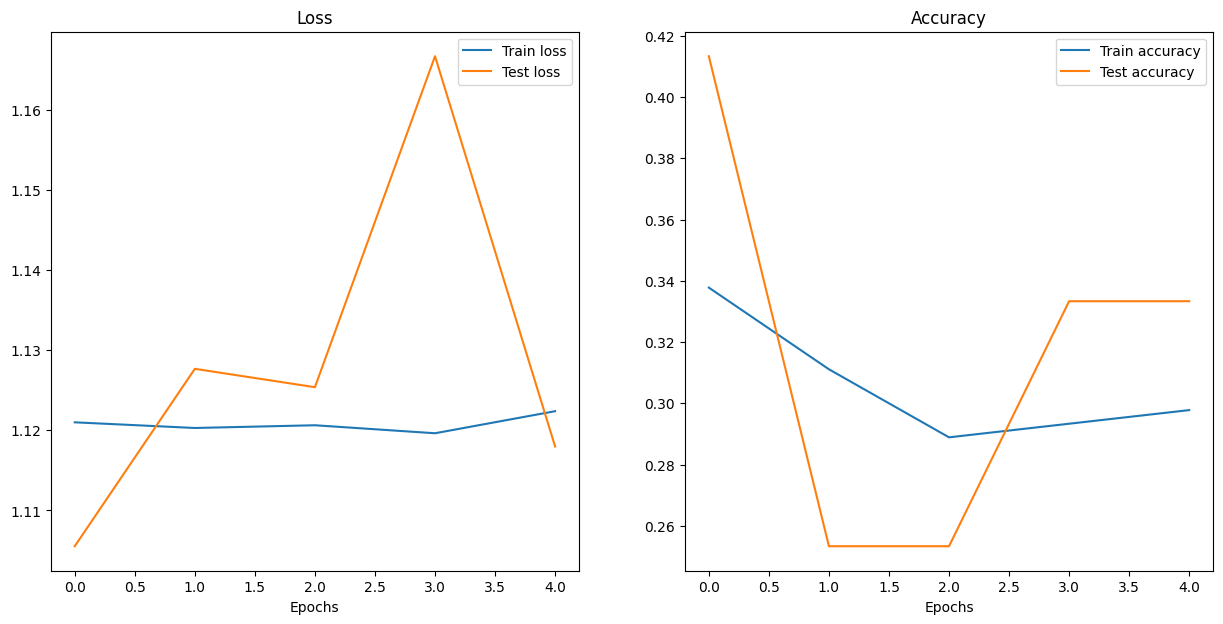

In [94]:
plot_loss_curve(model_0_results)

loss curve meanings:
1. When train/test curves not as low: Underfitting
2. When train loss much lower than test loss: Overfitting
3. When train/test curves are similar and line up over time: Perfect

#### How to deal with overfitting

- get more data
- simplify your model
- data augmentation
- transfer learning
- dropout layers
- learning rate decay
- early stopping

#### How to deal with underfitting

- add more layers/units to your model
- tweak learning rate
- use transfer learning
- train for longer
- use less regularization

### Model 1: TinyVGG with Data Augmentation

#### Create transforms with data augmentation

In [95]:
train_transforms_trivial_augment = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transforms_trivial_augment = simple_transform

#### Create train and test datasets and dataloaders

In [96]:
train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transforms_trivial_augment
)
test_data_augmented = datasets.ImageFolder(
    root=test_dir,
    transform=test_transforms_trivial_augment
)

In [97]:
batch_size = 32
num_workers = os.cpu_count()
torch.manual_seed(42)
train_loader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
)
test_loader_augmented = DataLoader(
    dataset=test_data_augmented,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)

#### Construct and train Model 1

In [98]:
torch.manual_seed(42)
model_1 = TinyVGG(
    input_dim=3,
    hidden_dim=10,
    output_dim=len(class_names)
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [99]:
torch.manual_seed(42)
num_epochs = 5
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.SGD(params=model_1.parameters(), lr=0.1)
start_time = timer()
model_1_results = train(
    model=model_1,
    train_loader=train_loader_augmented,
    test_loader=test_loader_augmented,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=num_epochs
)
end_time = timer()
print(f'Total train time: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_p

Epoch: 1 | train_loss: 1.1021 train_acc: 0.3477 test_loss: 1.2688 test_acc: 0.2604


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 2 | train_loss: 1.1054 train_acc: 0.4258 test_loss: 1.1357 test_acc: 0.2604


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 3 | train_loss: 1.0929 train_acc: 0.4258 test_loss: 1.1399 test_acc: 0.2604


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 4 | train_loss: 1.1093 train_acc: 0.3047 test_loss: 1.1362 test_acc: 0.2604


/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/hom

Epoch: 5 | train_loss: 1.0919 train_acc: 0.4258 test_loss: 1.1373 test_acc: 0.2604
Total train time: 303.438 seconds


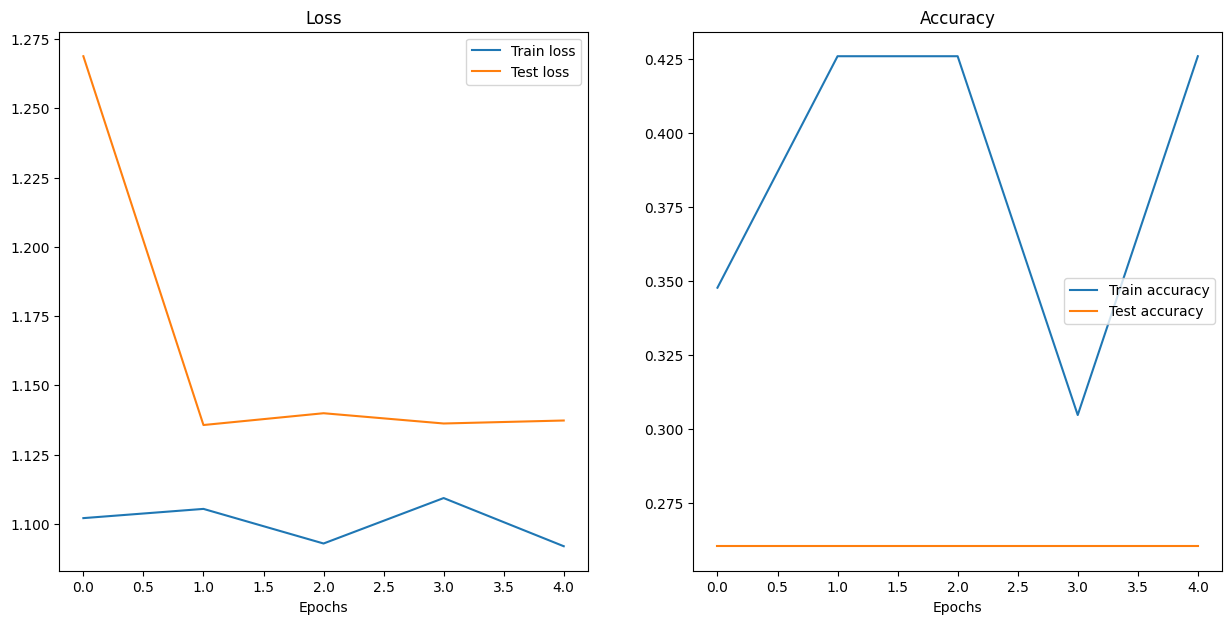

In [100]:
plot_loss_curve(model_1_results)

### Compare Model Results

In [102]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.121001,0.337778,1.105542,0.413333
1,1.120294,0.311111,1.127675,0.253333
2,1.120634,0.288889,1.125384,0.253333
3,1.119637,0.293333,1.166679,0.333333
4,1.122388,0.297778,1.117985,0.333333


In [103]:
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.102068,0.347656,1.268822,0.260417
1,1.105398,0.425781,1.135676,0.260417
2,1.092904,0.425781,1.139936,0.260417
3,1.109313,0.304688,1.136231,0.260417
4,1.091923,0.425781,1.137306,0.260417


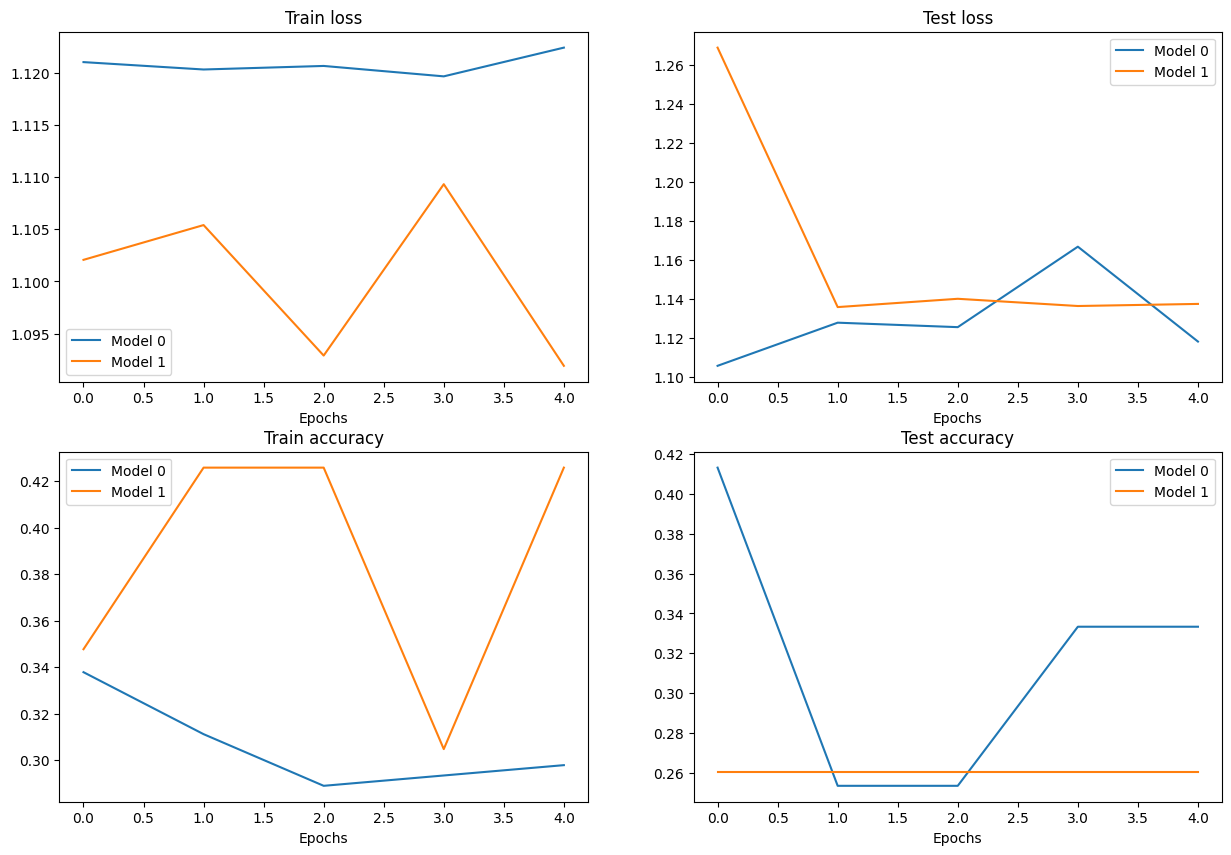

In [104]:
plt.figure(figsize=(15, 10))
epochs = range(len(model_0_df))
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label = 'Model 0')
plt.plot(epochs, model_1_df['train_loss'], label = 'Model 1')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label = 'Model 0')
plt.plot(epochs, model_1_df['test_loss'], label = 'Model 1')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label = 'Model 0')
plt.plot(epochs, model_1_df['train_acc'], label = 'Model 1')
plt.title('Train accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label = 'Model 0')
plt.plot(epochs, model_1_df['test_acc'], label = 'Model 1')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.legend()

### Make a prediction on a custom image

In [106]:
custom_img_path = data_path / '04-pizza-dad.jpeg'
if not custom_img_path.is_file():
    with open(custom_img_path, 'wb') as f:
        request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
        f.write(request.content)
else:
    print(f'{custom_img_path} already exists, skipping')

data/04-pizza-dad.jpeg already exists, skipping


#### Loading in custom image with PyTorch

In [108]:
custom_img_unit8 = torchvision.io.read_image(str(custom_img_path))

print(f'Custom img: {custom_img_unit8}')
print(f'Shape: {custom_img_unit8.shape}')
print(f'Dtype: {custom_img_unit8.dtype}')

Custom img: tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Shape: torch.Size([3, 4032, 3024])
Dtype: torch.uint8


In [109]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_img_unit8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [110]:
custom_img = custom_img_unit8.type(torch.float32)
custom_img /= 255. # get pixel vals between 0 and 1

print(f'Custom img: {custom_img}')
print(f'Shape: {custom_img.shape}')
print(f'Dtype: {custom_img.dtype}')

Custom img: tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549

#### Predict with trained PyTorch model

(-0.5, 3023.5, 4031.5, -0.5)

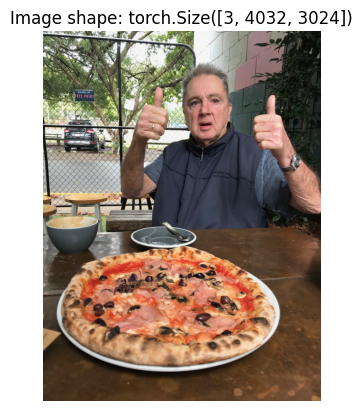

In [111]:
plt.imshow(custom_img.permute(1, 2, 0))
plt.title(f'Image shape: {custom_img.shape}')
plt.axis(False)

In [112]:
custom_img_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])
custom_img_transformed = custom_img_transform(custom_img)

print(f'Original shape: {custom_img.shape}')
print(f'Transformed shape: {custom_img_transformed.shape}')

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


(-0.5, 3023.5, 4031.5, -0.5)

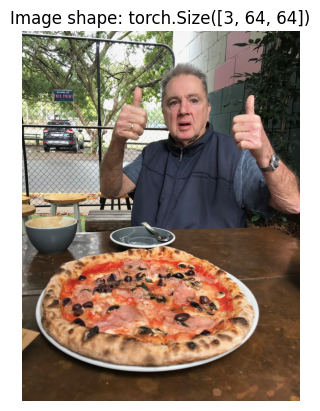

In [113]:
plt.imshow(custom_img.permute(1, 2, 0))
plt.title(f'Image shape: {custom_img_transformed.shape}')
plt.axis(False)

In [115]:
model_1.eval()
with torch.inference_mode():
    custom_img_pred = model_1(custom_img_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

WE FORGOT BATCH SIZE

In [117]:
model_1.eval()
with torch.inference_mode():
    custom_img_transformed_with_batch_size = custom_img_transformed.unsqueeze(dim = 0).to(device)
    custom_img_pred = model_1(custom_img_transformed_with_batch_size)

In [118]:
custom_img_pred

tensor([[ 0.1385, -0.0028, -0.1133]])

In [120]:
custom_img_predlabel = torch.softmax(custom_img_pred, dim=1).argmax(dim=1)
custom_img_predclass = class_names[custom_img_predlabel]
custom_img_predclass

'pizza'

In [123]:
def pred_and_plot(model, img_path, class_names = None, transform = None, device = device):
    target_img = torchvision.io.read_image(str(img_path)).type(torch.float32)
    target_img /= 255.

    if transform:
        target_img = transform(target_img)
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_img = target_img.unsqueeze(dim=0)
        target_img_pred = model(target_img)
        target_img_predlabel = torch.softmax(target_img_pred, dim=1).argmax(dim=1)
    plt.imshow(target_img.squeeze().permute(1, 2, 0))
    if class_names:
        title = f'Pred: {class_names[target_img_predlabel]}'
    else:
        title = f'Pred: {target_img_predlabel}'
    plt.title(title)
    plt.axis(False)

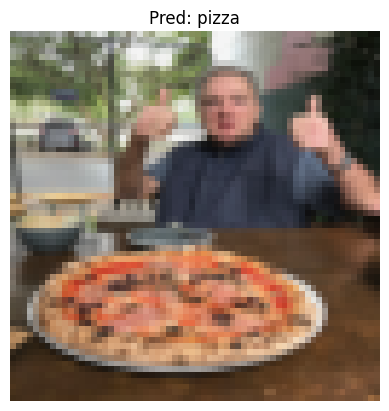

In [124]:
pred_and_plot(model_1, custom_img_path, class_names, custom_img_transform, device)